In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('Mental-Health-Twitter.csv', index_col=0)
df = df.drop(columns=["post_id"])

In [2]:
df['label'].value_counts()

label
1    10000
0    10000
Name: count, dtype: int64

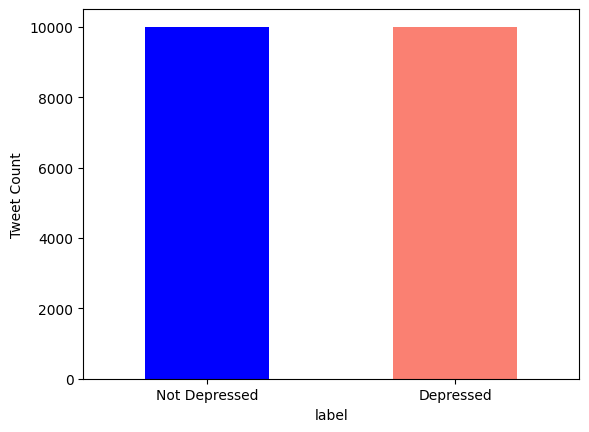

In [3]:
df['label'].value_counts().plot(kind='bar', color=['blue', 'salmon'])
plt.xticks(ticks=[0, 1], labels=["Not Depressed", "Depressed"], rotation=0)
plt.ylabel("Tweet Count")
plt.show()

In [4]:
df.head()

,post_created,post_text,user_id,followers,friends,favourites,statuses,retweets,label
0,Sun Aug 30 07:48:37 +0000 2015,It's just over 2 years since I was diagnosed w...,1013187241,84,211,251,837,0,1
1,Sun Aug 30 07:31:33 +0000 2015,"It's Sunday, I need a break, so I'm planning t...",1013187241,84,211,251,837,1,1
2,Sat Aug 29 22:11:07 +0000 2015,Awake but tired. I need to sleep but my brain ...,1013187241,84,211,251,837,0,1
3,Sat Aug 29 18:40:49 +0000 2015,RT @SewHQ: #Retro bears make perfect gifts and...,1013187241,84,211,251,837,2,1
4,Sat Aug 29 18:40:26 +0000 2015,It’s hard to say whether packing lists are mak...,1013187241,84,211,251,837,1,1


In [5]:
# Text Preprocessing

import re
import emoji
import spacy

nlp = spacy.load("en_core_web_sm")

def clean_batch(texts):
    cleaned = []

    for text in texts:
        # Lowercase
        text = text.lower()

        # Remove URLs, mentions, hashtags
        text = re.sub(r"http\S+|www\S+|https\S+", '', text)
        text = re.sub(r'\@\w+|\#', '', text)

        # Remove emojis
        text = emoji.replace_emoji(text, replace='')

        # Remove numbers and punctuation
        text = re.sub(r"[^a-zA-Z\s]", '', text)

        cleaned.append(text)

    # Now batch process with spaCy
    final = []
    for doc in nlp.pipe(cleaned, batch_size=50):
        tokens = [token.lemma_ for token in doc if not token.is_stop and len(token) > 1]
        final.append(" ".join(tokens))

    return final

df['post_text'] = df['post_text'].fillna("").astype(str)
df['clean_text'] = clean_batch(df['post_text'])

In [6]:
df['clean_text'].head()

0    year diagnose anxiety depression today take mo...
1    sunday need break plan spend little time possible
2                    awake tired need sleep brain idea
3    rt retro bear perfect gift great beginner stit...
4    hard packing list make life easy reinforce nee...
Name: clean_text, dtype: object

In [7]:
# Tf-idf Vectorization

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000,     # use top 5000 most informative words
                        ngram_range=(1, 1),    # unigrams + bigrams
                        min_df=5,              # ignore very rare words (appear in less than 5 tweets)
                        max_df=0.9,             # ignore super common words (appear in more than 90% of tweets)
                        sublinear_tf=True      # Applies 1 + log(tf) scaling instead of raw term frequency
                        )

X_text = tfidf.fit_transform(df['clean_text'])

X_text.shape

(20000, 3281)

In [8]:
# Feature Engineering

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack
from sklearn.model_selection import GroupShuffleSplit

# can help with signals like 'late-night posting'
df['post_created'] = pd.to_datetime(df['post_created'], errors='coerce')
df['hour'] = df['post_created'].dt.hour.fillna(0)
df['weekday'] = df['post_created'].dt.dayofweek.fillna(0)

# Create the splitter
split = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Split based on user_id
for train_idx, test_idx in split.split(df, groups=df['user_id']):
    train_df = df.iloc[train_idx]
    test_df = df.iloc[test_idx]

# Rebuild X_text (vectorized tweets) for both sets
X_train_text = tfidf.fit_transform(train_df['clean_text'])
X_test_text = tfidf.transform(test_df['clean_text'])

num_cols = ['friends', 'statuses', 'hour', 'weekday']
# statuses	    Low/high activity might correlate with mood
# friends	    Could reflect social connectedness

scaler = StandardScaler()
X_train_meta = scaler.fit_transform(train_df[num_cols])
X_test_meta = scaler.transform(test_df[num_cols])

# Combine features
X_train = hstack([X_train_text, X_train_meta])
X_test = hstack([X_test_text, X_test_meta])

y_train = train_df['label']
y_test = test_df['label']

/var/folders/k6/q3_zm6pj0h7gwwqjdk1_t6cm0000gn/T/ipykernel_68719/1877554926.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['post_created'] = pd.to_datetime(df['post_created'], errors='coerce')


In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)  

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.8883343730505302

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.98      0.82       809
           1       0.99      0.86      0.92      2397

    accuracy                           0.89      3206
   macro avg       0.85      0.92      0.87      3206
weighted avg       0.92      0.89      0.89      3206


Confusion Matrix:
 [[ 792   17]
 [ 341 2056]]


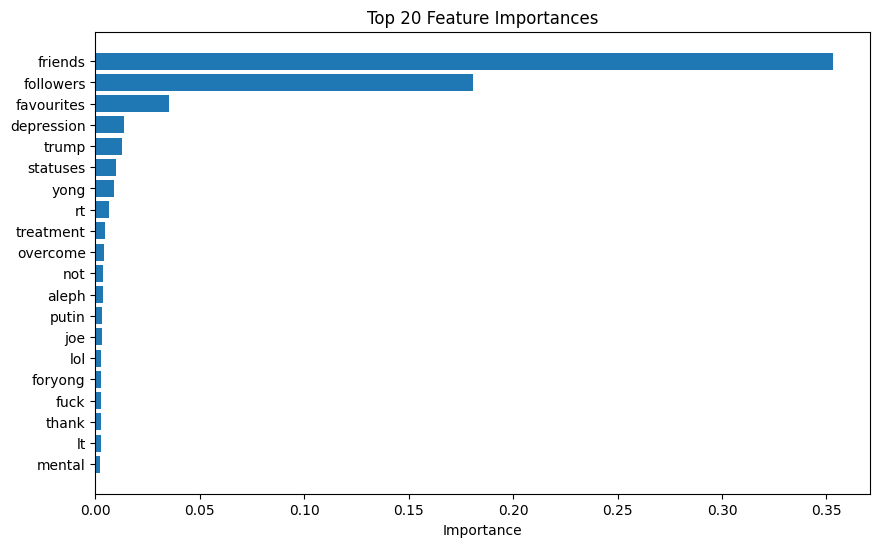

In [15]:
import numpy as np
import matplotlib.pyplot as plt

importances = rf_model.feature_importances_

text_features = tfidf.get_feature_names_out()
meta_features = ['followers', 'friends', 'favourites', 'statuses', 'retweets', 'hour', 'weekday']
used_meta = [col for col in meta_features if col in df.columns]
all_features = np.concatenate([text_features, used_meta])

indices = np.argsort(importances)[-20:]
plt.figure(figsize=(10, 6))
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), [all_features[i] for i in indices])
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance')
plt.show()


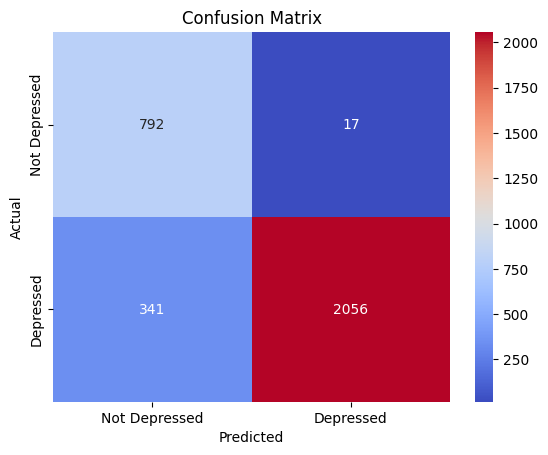

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
labels = ['Not Depressed', 'Depressed']

sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()